Using CUDA
Loaded 363069 images under train
Loaded 11932 images under val
Loaded 11965 images under test
Classes: 
['bar', 'line', 'pie']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


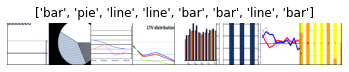

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

D:\Anaconda\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:182: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 6.00 GiB total capacity; 4.03 GiB already allocated; 35.00 MiB free; 4.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

def main():
  pass

if __name__ == '__main__':

    #Check to see if CUDA is availble on the running systems.
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        print("Using CUDA")

    # Loading this dataset with pytorch is really easy using ImageFolder
    # as the labels are specified by the folders names.
    # This folder path will be custom for each member
    data_dir = r'D:\School\SE\Group_Project\data'
    TRAIN = 'train'
    VAL = 'val'
    TEST = 'test'

    # VGG-16 Takes 224x224 images as input, so we resize all of them
    #it also takes normalization as specified at pytorch.com
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally (seems like best fit for graphs?)
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
        VAL: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }

    #creating our data set
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x),
            transform=data_transforms[x]
        )
        for x in [TRAIN, VAL, TEST]
    }

    #low batch sizes allow for our computers to compute these predicitions as they don't use much
    #video memory
    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=8,
            shuffle=True, num_workers=4
        )
        for x in [TRAIN, VAL, TEST]
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

    for x in [TRAIN, VAL, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))


    print("Classes: ")
    class_names = image_datasets[TRAIN].classes
    print(image_datasets[TRAIN].classes)


#     def imshow(inp, title=None):
#         """Imshow for Tensor."""
#         inp = inp.numpy().transpose((1, 2, 0))
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         inp = std * inp + mean
#         inp = np.clip(inp, 0, 1)
#         plt.imshow(inp)
#         if title is not None:
#             plt.title(title)
#         plt.pause(0.001)  # pause a bit so that plots are updated

#     #Get a batch of training data
#     inputs, classes = next(iter(dataloaders[TRAIN]))
#     #Make a grid from batch
#     out = torchvision.utils.make_grid(inputs)
#     imshow(out, title=[class_names[x] for x in classes])

    
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        # plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)
    
    
    
    def show_databatch(inputs, classes):
        out = torchvision.utils.make_grid(inputs)
        imshow(out, title=[class_names[x] for x in classes])
    
    
    inputs, classes = next(iter(dataloaders[TRAIN]))
    show_databatch(inputs, classes)
    
    #allows the itegration of matplot lib to see some data
    def visualize_model(vgg, num_images=6):
        was_training = vgg.training
    
        # Set model for evaluation
        vgg.train(False)
        vgg.eval()
    
        images_so_far = 0
    
        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]
    
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
    
            outputs = vgg(inputs)
    
            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]
    
            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
    
            del inputs, labels, outputs, preds, predicted_labels
            torch.cuda.empty_cache()
    
            images_so_far += size
            if images_so_far >= num_images:
                break
    
        vgg.train(mode=was_training)  # Revert model back to original training state
    
    #pretraining evaluation
    def eval_model(vgg, criterion):
        since = time.time()
        avg_loss = 0
        avg_acc = 0
        loss_test = 0
        acc_test = 0
    
        test_batches = len(dataloaders[TEST])
        print("Evaluating model")
        print('-' * 10)
    
        for i, data in enumerate(dataloaders[TEST]):
            if i % 100 == 0:
                print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)
    
            vgg.train(False)
            vgg.eval()
            inputs, labels = data
    
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
    
            outputs = vgg(inputs)
    
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
    
            loss_test += loss.data
            acc_test += torch.sum(preds == labels.data)
    
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
    
        avg_loss = loss_test / dataset_sizes[TEST]
        avg_acc = acc_test / dataset_sizes[TEST]
    
        elapsed_time = time.time() - since
        print()
        print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Avg loss (test): {:.4f}".format(avg_loss))
        print("Avg acc (test): {:.4f}".format(avg_acc))
        print('-' * 10)
    
    
    # # Load the pretrained model from pytorch
    vgg16 = models.vgg16_bn()

    # #vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
    print(vgg16.classifier[6].out_features)  # 1000
    
    # Freeze training for all layers
    for param in vgg16.features.parameters():
        param.require_grad = False
    
    # Newly created modules have require_grad=True by default
    num_features = vgg16.classifier[6].in_features
    features = list(vgg16.classifier.children())[:-1]  # Remove last layer
    features.extend([nn.Linear(num_features, len(class_names))])  # Add our layer with 4 outputs
    vgg16.classifier = nn.Sequential(*features)  # Replace the model classifier
    print(vgg16)
    
    
    
    # If you want to train the model for more than 2 epochs,
    # set this to True after the first run
    resume_training = False
    
    if resume_training:
        print("Loading pretrained model..")
        vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
        print("Loaded!")
    
    if use_gpu:
        vgg16.cuda()  # .cuda() will move everything to the GPU side
    
    criterion = nn.CrossEntropyLoss()

    #optimization (possibly could use atom)
    optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    
    
    print("Test before training")
    eval_model(vgg16, criterion)
    
    
    visualize_model(vgg16) #test before training

    #(training the actual model)
    def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
        since = time.time()
        best_model_wts = copy.deepcopy(vgg.state_dict())
        best_acc = 0.0

        avg_loss = 0
        avg_acc = 0
        avg_loss_val = 0
        avg_acc_val = 0

        train_batches = len(dataloaders[TRAIN])
        val_batches = len(dataloaders[VAL])

        for epoch in range(num_epochs):
            print("Epoch {}/{}".format(epoch, num_epochs))
            print('-' * 10)

            loss_train = 0
            loss_val = 0
            acc_train = 0
            acc_val = 0

            vgg.train(True)

            for i, data in enumerate(dataloaders[TRAIN]):
                if i % 100 == 0:
                    print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

                # Use half training dataset
                if i >= train_batches / 2:
                    break

                inputs, labels = data

                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                loss_train += loss.data
                acc_train += torch.sum(preds == labels.data)

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

            print()
            # * 2 as we only used half of the dataset
            avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
            avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

            vgg.train(False)
            vgg.eval()

            for i, data in enumerate(dataloaders[VAL]):
                if i % 100 == 0:
                    print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
                else:
                    inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

                optimizer.zero_grad()

                outputs = vgg(inputs)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.data[0]
                acc_val += torch.sum(preds == labels.data)

                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()

            avg_loss_val = loss_val / dataset_sizes[VAL]
            avg_acc_val = acc_val / dataset_sizes[VAL]

            print()
            print("Epoch {} result: ".format(epoch))
            print("Avg loss (train): {:.4f}".format(avg_loss))
            print("Avg acc (train): {:.4f}".format(avg_acc))
            print("Avg loss (val): {:.4f}".format(avg_loss_val))
            print("Avg acc (val): {:.4f}".format(avg_acc_val))
            print('-' * 10)
            print()

            if avg_acc_val > best_acc:
                best_acc = avg_acc_val
                best_model_wts = copy.deepcopy(vgg.state_dict())

        elapsed_time = time.time() - since
        print()
        print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        print("Best acc: {:.4f}".format(best_acc))

        vgg.load_state_dict(best_model_wts)
        return vgg
    
    vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

    #take this model and use the data in the remainder of the picture in the testing folder
    torch.save(vgg16.state_dict(), 'VGG16_graphs.pt')
